RelapseFreeSurvival (outcome)
38.000000    11
39.000000    10
60.000000    10
31.000000     9
61.000000     9
             ..
0.000000      1
8.000000      1
77.250000     1
53.583333     1
46.916667     1
Name: count, Length: 144, dtype: int64


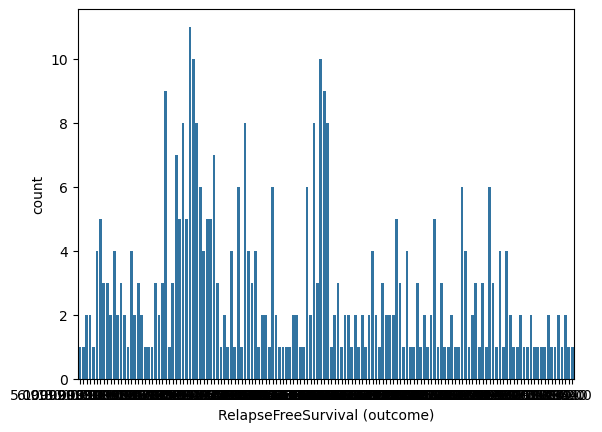

In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("..\output.csv")
# df.head()
# df.describe()
# df.info()

# # 删除 "ID" 列
# df.drop("ID", axis=1, inplace=True)
# df.head()

# from sklearn.impute import SimpleImputer

# # 用中位数填充缺失值
# imputer = SimpleImputer(strategy='median')
# df.replace(999, np.nan, inplace=True)
# df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
# df.describe()

import seaborn as sns

# 打印回归目标变量的分布
print(df['RelapseFreeSurvival (outcome)'].value_counts())
sns.countplot(x="RelapseFreeSurvival (outcome)", data=df)

# 将目标变量赋值为回归任务的 y_reg
y_reg = df["RelapseFreeSurvival (outcome)"]

# 删除回归目标变量列
df.drop("RelapseFreeSurvival (outcome)", axis=1, inplace=True)
df.drop("pCR (outcome)", axis=1, inplace=True)


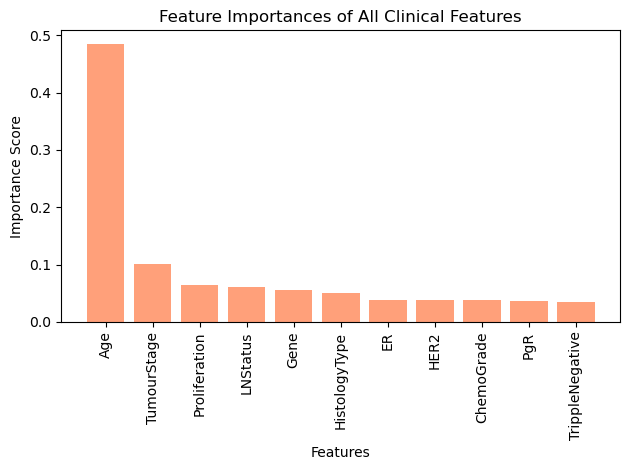

In [369]:

# 重新分配自变量
X_clinical = df.iloc[:, :11]
X_mri = df.iloc[:, 11:]

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

# 使用随机森林回归器进行特征选择
model_all = RandomForestRegressor(random_state=42)
model_all.fit(X_clinical, y_reg)

all_importances = model_all.feature_importances_
indices = np.argsort(all_importances)[::-1]

plt.figure()
plt.title("Feature Importances of All Clinical Features")
plt.bar(X_clinical.columns[indices], all_importances[indices], color="lightsalmon", align="center")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [370]:

# 使用 RFECV 进行递归特征消除
# model = RandomForestRegressor(random_state=42)

# rfecv = RFECV(estimator=model, step=1, cv=5, scoring='r2')
# rfecv.fit(X_clinical, y_reg)

# selected_features = X_clinical.columns[rfecv.support_]
# print("Optimal Number of Features:", rfecv.n_features_)
# print("Selected Features:")
# print(selected_features)
#X_clinical_fs = X_clinical[selected_features]
X_clinical_fs = X_clinical["Age"]


In [371]:
# from sklearn.linear_model import Lasso
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# import numpy as np

# # 数据标准化
# scaler = StandardScaler()
# X_clinical_scaled = scaler.fit_transform(X_clinical)

# # 使用 Lasso，减小 alpha 值
# lasso = Lasso(alpha=1)  # 调整 alpha 为较小的值
# lasso.fit(X_clinical_scaled, y_reg)

# # 获取 LASSO 回归模型的系数
# lasso_coefficients = lasso.coef_

# # 获取非零系数对应的特征
# non_zero_features = X_clinical.columns[lasso_coefficients != 0]

# # 输出 LASSO 回归模型的非零系数特征
# print("Non-zero features selected by LASSO:", non_zero_features)

# # 可视化 LASSO 模型的系数
# plt.figure(figsize=(10, 6))
# plt.bar(X_clinical.columns, lasso_coefficients, color="lightcoral")
# plt.xticks(rotation=90)
# plt.title("LASSO Coefficients")
# plt.xlabel("Features")
# plt.ylabel("Coefficient Magnitude")
# plt.tight_layout()
# plt.show()

# # 输出被选中的特征和它们的系数
# selected_features = X_clinical.columns[lasso_coefficients != 0]
# selected_coefficients = lasso_coefficients[lasso_coefficients != 0]
# print("Selected features with their coefficients:")
# for feature, coef in zip(selected_features, selected_coefficients):
#     print(f"{feature}: {coef}")
# X_clinical_fs = X_clinical[selected_features]
# print(X_clinical_fs.shape)

In [372]:

# 使用 PCA 降维
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_mri = scaler.fit_transform(X_mri)

pca = PCA(n_components=5)
X_mri_dr = pca.fit_transform(X_mri)

print("Number of Components Selected:", pca.n_components_)
print(X_clinical_fs.shape, type(X_clinical_fs))
print(X_mri_dr.shape, type(X_mri_dr))

# 合并临床特征和MRI特征
X = np.hstack((X_clinical_fs.values.reshape(-1, 1), X_mri_dr))
X.shape, type(X.shape)


Number of Components Selected: 5
(400,) <class 'pandas.core.series.Series'>
(400, 5) <class 'numpy.ndarray'>


((400, 6), tuple)

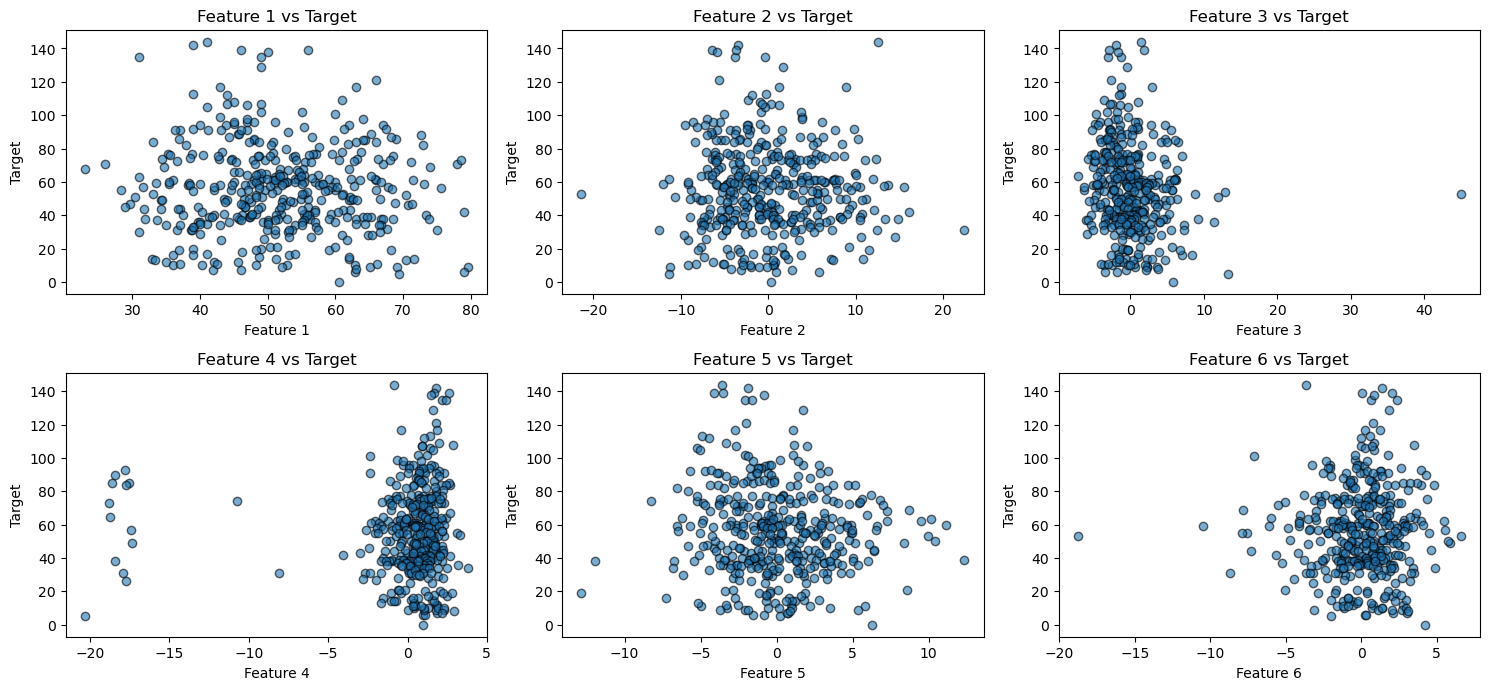

In [373]:
import matplotlib.pyplot as plt
import numpy as np


# 创建散点图
plt.figure(figsize=(15, 10))
for i in range(X.shape[1]):  # X 中有 8 个特征
    plt.subplot(3, 3, i + 1)
    plt.scatter(X[:, i], y_reg, alpha=0.6, edgecolor='k')
    plt.title(f'Feature {i+1} vs Target')
    plt.xlabel(f'Feature {i+1}')
    plt.ylabel('Target')

plt.tight_layout()
plt.show()


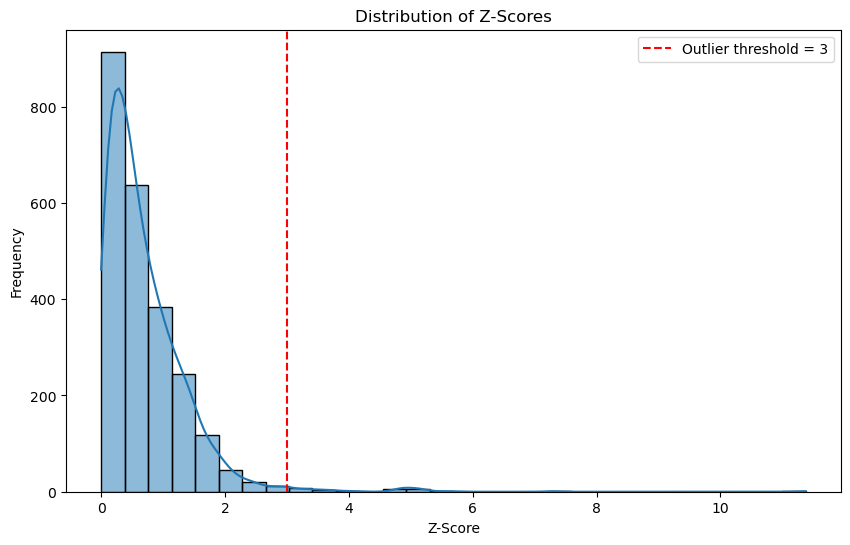

Removed 24 outliers from the data.
(376, 6) (376,)


In [374]:

# # 计算 Z 分数，检测异常值
# from scipy.stats import zscore

# z_scores = np.abs(zscore(X))
# #z_scores = z_scores.to_numpy()
# z_scores_flat = z_scores.flatten()

# plt.figure(figsize=(10, 6))
# sns.histplot(z_scores_flat, bins=30, kde=True)
# plt.title("Distribution of Z-Scores")
# plt.xlabel("Z-Score")
# plt.ylabel("Frequency")
# plt.axvline(x=3, color='r', linestyle='--', label="Outlier threshold = 3 ")
# plt.legend()
# plt.show()


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# 假设 X 是特征，y_reg 是目标变量

# 计算 Z-Score
z_scores = zscore(X)

# 计算所有特征的 Z-Score的绝对值
z_scores_flat = np.abs(z_scores).flatten()

# 绘制 Z-Score 分布图
plt.figure(figsize=(10, 6))
sns.histplot(z_scores_flat, bins=30, kde=True)
plt.title("Distribution of Z-Scores")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.axvline(x=3, color='r', linestyle='--', label="Outlier threshold = 3")
plt.legend()
plt.show()

# 设置 Z-Score 阈值
threshold = 3

# 找到所有 Z-Score 超过阈值的样本（每个特征的 Z-Score 超过阈值的样本）
outliers = (np.abs(z_scores) > threshold).any(axis=1)  # 检查任意一个特征的 Z-Score 是否超出阈值

# 删除异常值
X = X[~outliers]
y_reg = y_reg[~outliers]

# 输出去除的异常值个数
print(f"Removed {np.sum(outliers)} outliers from the data.")
print(X.shape, y_reg.shape)


最佳参数: {'C': 0.1, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
最佳得分: -681.0104243097079
SVR Mean Squared Error: 998.808193740578
SVR R^2 Score: -0.0523853414594051


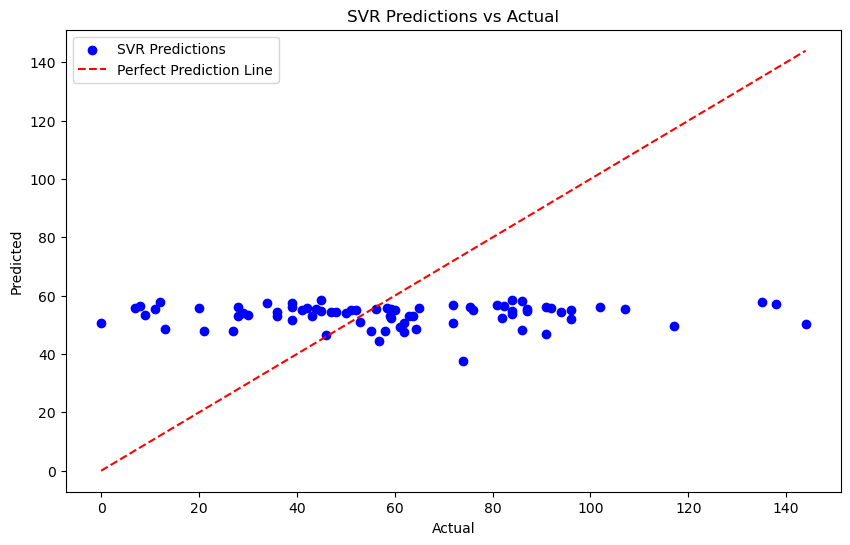

In [375]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.20, random_state=42)

#标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# # 1. 支持向量回归 (SVR)
# svr = SVR(kernel='linear', C=100, epsilon=0.1)
# svr.fit(X_train, y_train)

# # 预测
# y_pred_svr = svr.predict(X_test)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

# 网格搜索
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 最佳参数
print("最佳参数:", grid_search.best_params_)
print("最佳得分:", grid_search.best_score_)

# 使用最佳参数预测
best_model = grid_search.best_estimator_
y_pred_svr = best_model.predict(X_test)


# 评估性能
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR Mean Squared Error:", mse_svr)
print("SVR R^2 Score:", r2_svr)


# for actual, predicted in zip(y_test, y_pred_svr):
#     print(f"Actual: {actual}, Predicted: {predicted}")

# 可视化结果（SVR）
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, color='blue', label='SVR Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction Line")
plt.title("SVR Predictions vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()



Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Model R^2 on Training: -0.19184686935942552
Decision Tree Mean Squared Error: 1047.5002090605506
Decision Tree R^2 Score: -0.10368924894633702


c:\MyAPPs\Anaconda3\envs\MLE\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


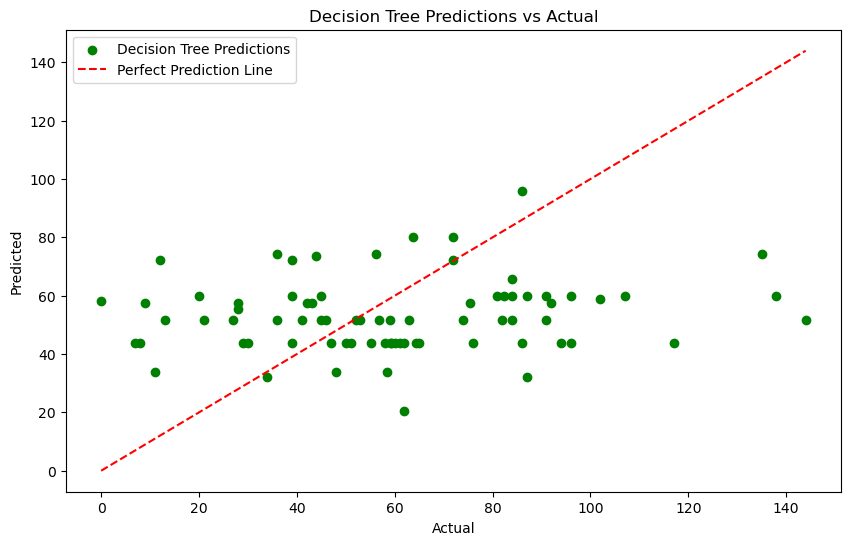

In [376]:

# # 2. 决策树回归 (Decision Tree Regressor)
# dt_regressor = DecisionTreeRegressor(random_state=42)
# dt_regressor.fit(X_train, y_train)

# # 预测
# y_pred_dt = dt_regressor.predict(X_test)

# # 评估性能


from sklearn.model_selection import GridSearchCV

# 定义超参数网格
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

# 初始化决策树回归模型
dt_regressor = DecisionTreeRegressor(random_state=42)

# 进行网格搜索
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, 
                           scoring='r2', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 获取最佳参数
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred_dt = best_model.predict(X_test)

print("Best Parameters:", best_params)
print("Best Model R^2 on Training:", grid_search.best_score_)

mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree Mean Squared Error:", mse_dt)
print("Decision Tree R^2 Score:", r2_dt)

# 可视化结果（Decision Tree）
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_dt, color='green', label='Decision Tree Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Prediction Line")
plt.title("Decision Tree Predictions vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()


Linear Regression Mean Squared Error: 1059.0192359224382
Linear Regression R^2 Score: -0.11582616882074093


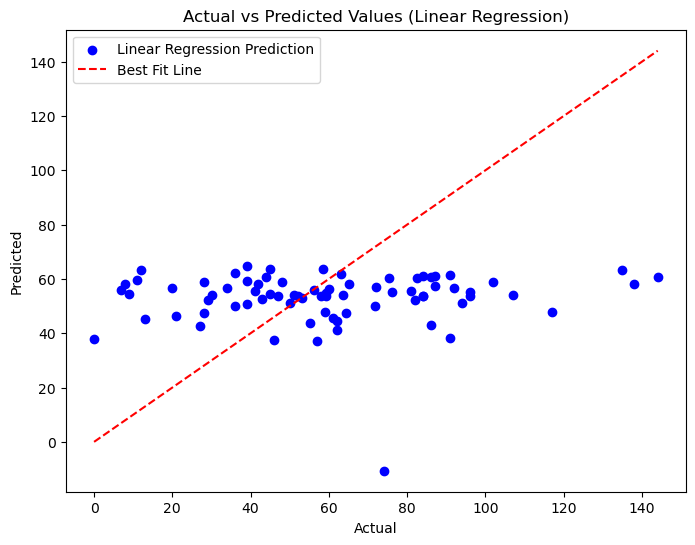

In [377]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()

# 训练线性回归模型
lr_model.fit(X_train, y_train)

# 对测试集进行预测
y_pred = lr_model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Mean Squared Error: {mse}")
print(f"Linear Regression R^2 Score: {r2}")

# 可视化回归结果
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Linear Regression Prediction')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label = "Best Fit Line")  # 线性拟合线
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values (Linear Regression)")
plt.legend()
plt.show()

MLPRegressor Mean Squared Error: 1080.450249503332
MLPRegressor R^2 Score: -0.1384067650618328


c:\MyAPPs\Anaconda3\envs\MLE\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


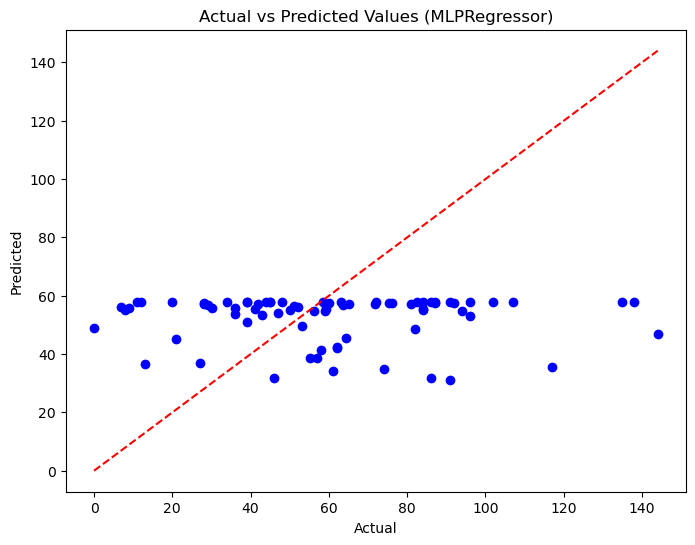

In [383]:
# 构建MLP回归模型
from sklearn.neural_network import MLPRegressor


model_mlp = MLPRegressor(hidden_layer_sizes=(128, 64), activation='logistic', solver='adam', max_iter=2000, alpha=0.0001, random_state=42)

# 训练模型
model_mlp.fit(X_train, y_train)

# 预测
y_pred = model_mlp.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MLPRegressor Mean Squared Error: {mse}")
print(f"MLPRegressor R^2 Score: {r2}")

# 可视化回归结果
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 线性拟合线
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values (MLPRegressor)")
plt.show()


In [379]:

# from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# import matplotlib.pyplot as plt

# # 定义参数范围
# param_grid = {
#     'hidden_layer_sizes': [(64,), (128,), (64, 64), (128, 64), (128, 128)],
#     'activation': ['relu', 'tanh', 'logistic'],
#     'solver': ['adam', 'sgd', 'lbfgs'],
#     'max_iter': [1000, 2000, 5000],
#     'alpha': [0.0001, 0.001, 0.01],
# }

# # 创建 MLPRegressor 模型
# model_mlp = MLPRegressor(random_state=42)

# # 使用 GridSearchCV 进行参数调优
# grid_search = GridSearchCV(estimator=model_mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# # 训练模型
# grid_search.fit(X_train, y_train)

# # 输出最优参数
# print(f"Best parameters found: {grid_search.best_params_}")

# # 使用最优参数进行预测
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # 评估模型性能
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Optimized MLPRegressor Mean Squared Error: {mse}")
# print(f"Optimized MLPRegressor R^2 Score: {r2}")

# # 可视化回归结果
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, color='blue', label='MLPRegressor Predictions')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Best Fit Line')  # 线性拟合线
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.title("Actual vs Predicted Values (Optimized MLPRegressor)")
# plt.legend()
# plt.show()


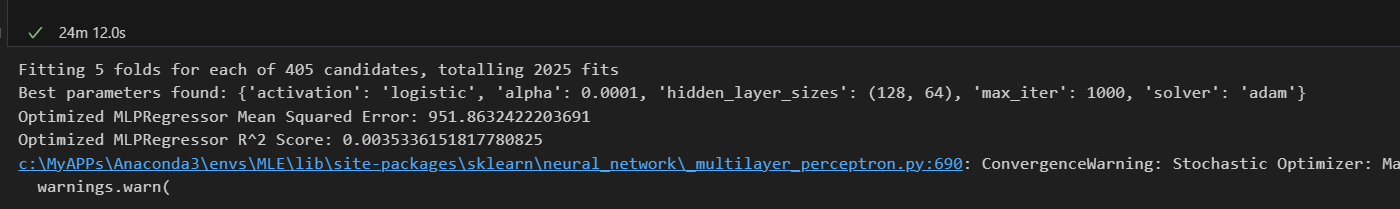